# Machine Learning in Python - Project 2

Due Friday, April 12th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here and load data*

In [64]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split

In [151]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,int_rt,channel,ppmt_pnlty,prod_type,st,prop_type,zipcode,id_loan,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,prepaid,default
0,709.0,201703,9,204702,NaN,12,1,P,84,26,310000,84,3.625,R,N,FRM,IA,SF,51300,F117Q1000376,N,360,2,Other sellers,Other servicers,NaN,0,1
1,649.0,201703,9,203202,33124.0,0,1,P,52,22,190000,52,2.875,R,N,FRM,FL,SF,33100,F117Q1000418,C,180,2,Other sellers,Other servicers,NaN,1,0
2,747.0,201703,9,203702,41180.0,0,1,I,43,20,61000,43,4.000,R,N,FRM,MO,SF,63100,F117Q1000479,N,240,2,Other sellers,Other servicers,NaN,1,0
3,711.0,201703,9,204702,20260.0,0,1,I,80,21,90000,80,4.625,R,N,FRM,MN,SF,55800,F117Q1000523,P,360,2,Other sellers,Other servicers,NaN,1,0
4,751.0,201703,N,204702,NaN,35,1,P,95,24,112000,95,4.250,R,N,FRM,TX,PU,75900,F117Q1000719,P,360,1,Other sellers,ARVESTCENTRALMTGECO,NaN,1,0


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. FreddiMac company or similar company). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Feature engineering that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*If you decide to extract additional features from the full data (easyshare_all.csv), describe these variables here.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

**variable summary**

Numerical variable `fico` (credit score); 

Categorical variable `dt_first_pi` (date of the first mortgage payment), it's a 6-digit number with format YYYYMM. From year 2017 to 2019.

Categorical variable `dt_matr` (maturity date, date of the last mortgage payment), it's a 6-digit number with format YYYYMM. From 202504 to 204812.

Binary variable `flag_fthb` (first time homebuyer), with missing value encoded with 9.

Numerical variable `orig_upb` (loan amount that has not yet been paid off);

Numerical variable `int_rt` (interest rate of the loan);

Identifier `cd_msa`, they are 5-digit codes of Metropolitan Statistical Area (MSA) regions in the US, where the complete list of encodings can be found in this [document](https://www2.census.gov/programs-surveys/cps/methodology/Geographic%20Coding%20-%20Metro%20Areas%20(since%20August%202005).pdf).

Categorical variable `mi_pct` (percentage of the loan amount that's required for mortgage insurance. It is often required when the borrower's down payment on a home is less than a certain percentage of the home's purchase price.) It's classified as categorical because only there's only 7 insurance levels:  0,6,12,20,25,30,35.

Categorical variable `cnt_units` (number of units in the morgaged property), 4 levels: 1,2,3,4.

Categorical variable `occpy_sts` (mortgage type), 3 levels: owner occupied (P), second home (S), or investment property (I).

Numerical variable `cltv` (rate of loan amount to total property value, e.g. $90\%$);

Numerical variable `dti` (debt-to-income ratio, which is calculated by monthly housing expenses that incorporate the mortgage payment, divided by the monthly income used to underwrite the loan);

Numerical variable `ltv` (loan-to-value). For example, if a borrower takes out a mortgage for £150,000 to purchase a home that is appraised at £$200,000$, the original loan-to-value ratio would be $\frac{150,000}{200,000} = 0.75$, or $75\%$. This means that the borrower is financing $75\%$ of the property's value with the mortgage loan, and the remaining $25\%$ is covered by the borrower's down payment or equity.

Numerical variable `int_rt` (interest rate of the property);

Categorical variable `channel`;

Binary variable `ppmt_pnlty`, with Yes or No (penalty applied). A prepayment penalty is a fee charged by lenders if the borrower pays off the mortgage loan before the agreed-upon term. Note there's no Y instance in this dataset.

Binary variable `prod_type` only fixed-rate mortgage in this dataset.

Categorical variable `st` (US states) two-letter abbreviations;

Categorical variable `prop_type`, property type: condominium (CO), planned unit development (PU), cooperative share (CP), manufactured home (MH), or Single-Family home (SF).

Identifier `zipcode`, they are 5-digit codes in the form of ###00;

Identifier `id_loan`, unique ID for each entry;

Categorical variable `loan_purpose `, Cash-out Refinance mortgage (C), No Cash-out Refinance mortgage (N), Refinance mortgage not specified (R), or a Purchase mortgage (P);

Numerical variable `orig_loan_term`, number of monthly payments from first payment until maturity date.

Binary variable `cnt_borr`, the number of borrower(s) who're obligated to pay the mortgage. 1 = one borrower, 2 = more than one borrower.

Categorical variable `seller_name`, list of names of seller of mortgages.

Categorical variable `servicer_name`, list of names of servicer of mortgages.

Binary variable `flag_sc`, all entries either have Y or NaN.

Binary variable `default`, our response variable, 1=default, 0=no default.

**Missing value analysis** 

There is $1$ missing value for `fico` (credit score);

$3468$ NA values for `flag_fthb` (binary, first time homebuyer);

$594$ null values for `cd_msa` (metropolitan statistical area), indicating $594$ mortgaged properties are either not in a Metropolitan Area or MSA status unknown;

$1$ NA for `cltv`;

$1$ NA for `dti`, indicating $1$ impossible value of $>65\%$;

$1$ NA for `ltv`;

$38$ missing values for `ppmt_pnlty`,

$5751$ missing values for `flag_sc`.

In [149]:
missing_values_count = d.isnull().sum()
missing_values_table = pd.DataFrame({'Missing Values': missing_values_count})

print("Table of Null Values in Each Variable:")
print(missing_values_table)
count_9999 = d['fico'].astype(str).str.count('9999').sum()
print("Number of NA (encoded as 9999) in 'fico':", count_9999)
count_9 = d['flag_fthb'].astype(str).str.count('9').sum()
print("Number of NA (encoded as 9) in 'flag_fthb':", count_9)
count_999 = d['mi_pct'].astype(str).str.count('999').sum()
print("Number of NA (999) in 'mi_pct':", count_999)
count_99 = d['cnt_units'].astype(str).str.count('99').sum()
print("Number of no information (99) in 'cnt_units':", count_99)
c9 = d['occpy_sts'].astype(str).str.count('9').sum()
print("Number of no information (9) in 'occpy_sts':", c9)
c999 = d['cltv'].astype(str).str.count('999').sum()
print("Number of no information (999) in 'cltv':", c999)
c_999 = d['dti'].astype(str).str.count('999').sum()
print("Number of NA (999) in 'dti':", c_999)
co_999 = d['ltv'].astype(str).str.count('999').sum()
print("Number of NA (999) in 'ltv':", co_999)
co_9 = d['channel'].astype(str).str.count('9').sum()
print("Number of NA (9) in 'channel':", co_9)
co_99 = d['prop_type'].astype(str).str.count('99').sum()
print("Number of NA (99) in 'prop_type':", co_99)
c_00 = d['zipcode'].astype(str).str.count('###00').sum()
print("Number of NA in 'zipcode':", c_00)
cou_9 = d['loan_purpose'].astype(str).str.count('9').sum()
print("Number of NA in 'loan_purpose':", cou_9)

Table of Null Values in Each Variable:
                Missing Values
fico                         1
dt_first_pi                  0
flag_fthb                    0
dt_matr                      0
cd_msa                     594
mi_pct                       0
cnt_units                    0
occpy_sts                    0
cltv                         0
dti                          0
orig_upb                     0
ltv                          0
int_rt                       0
channel                      0
ppmt_pnlty                  38
prod_type                    0
st                           0
prop_type                    0
zipcode                      0
id_loan                      0
loan_purpose                 0
orig_loan_term               0
cnt_borr                     0
seller_name                  0
servicer_name                0
flag_sc                   5751
prepaid                      0
default                      0
Number of NA (encoded as 9999) in 'fico': 0
Number of NA (enco

**Training and testing data split**: $90\%$ and $10\%$ of the data are allocated to training and testing dataset, respectively.

In [152]:
X = d.drop(columns=['default'])
y = d['default']  # Response variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

**Numerical variables**: the density plots, boxplots, heatmap and scatterplots of all continuous numerical variables.

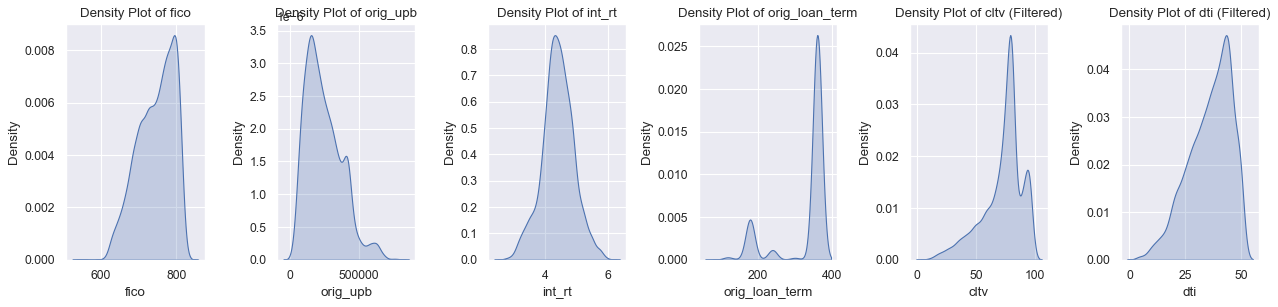

In [141]:
# filter NA coded as 999
filtered_cltv = X_train[X_train['cltv'] != 999]['cltv']
filtered_dti = X_train[X_train['dti'] != 999]['dti']
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16, 4))

# Numerical variables
num_var = ['fico', 'orig_upb', 'int_rt','orig_loan_term']
for i, variable in enumerate(num_var):
    sns.kdeplot(data=X_train[variable], ax=axes[i], fill=True)
    axes[i].set_title(f'Density Plot of {variable}')
sns.kdeplot(data=filtered_cltv, ax=axes[-2], fill=True)
axes[-2].set_title('Density Plot of cltv (Filtered)')
sns.kdeplot(data=filtered_dti, ax=axes[-1], fill=True)
axes[-1].set_title('Density Plot of dti (Filtered)')
plt.tight_layout()
plt.show()

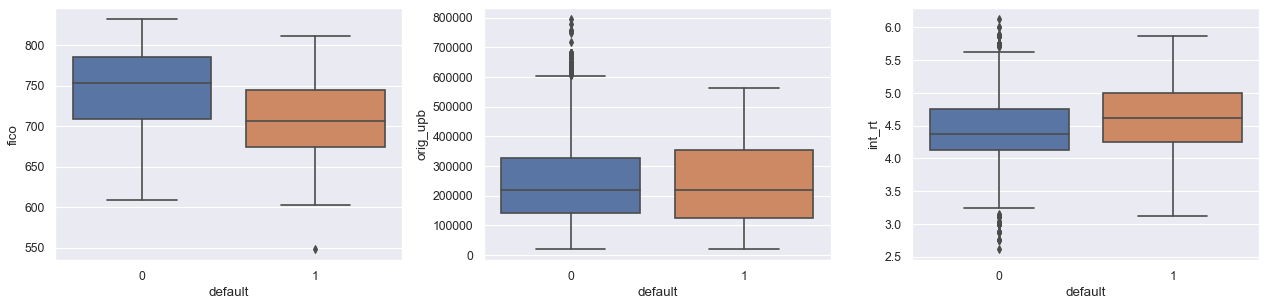

In [119]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

# Looping through the numerical variables and creating the boxplots
for i, var in enumerate(num_var):
    sns.boxplot(x=y_train, y=X_train[var], ax=axes[i])

# Displaying the plot
plt.tight_layout()
plt.show()

In [103]:
# set na
for column in d[num_var].columns:
    Q1 = d[num_var][column].quantile(0.25)
    Q3 = d[num_var][column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    d[column] = d[num_var][column].mask((d[num_var][column] < lower_bound) | (d[num_var][column] > upper_bound), np.nan)

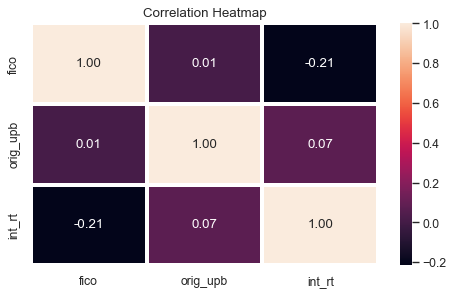

In [104]:
sns.set(rc={'figure.figsize': (7, 4)})
sns.heatmap(X_train[num_var].corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()

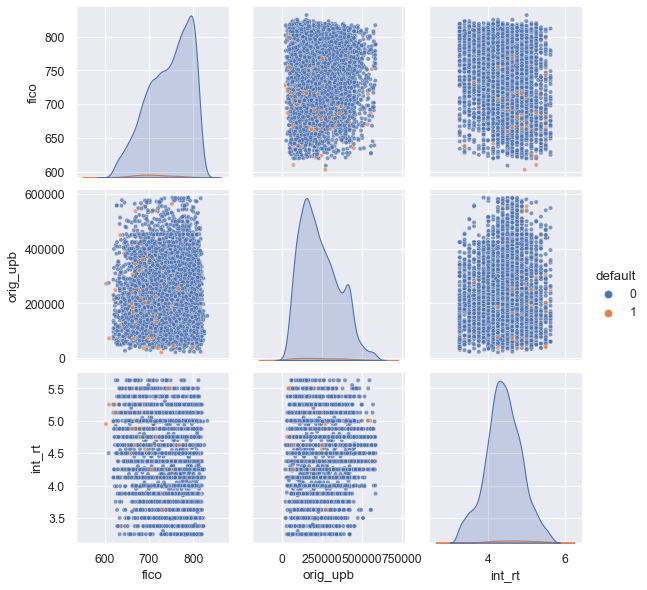

In [105]:
sns.pairplot(data=d, vars=num_var, hue="default", plot_kws={'alpha': 0.7, 's': 15})

**Categorical variables**: Below displays the bar charts of all categorical variables.

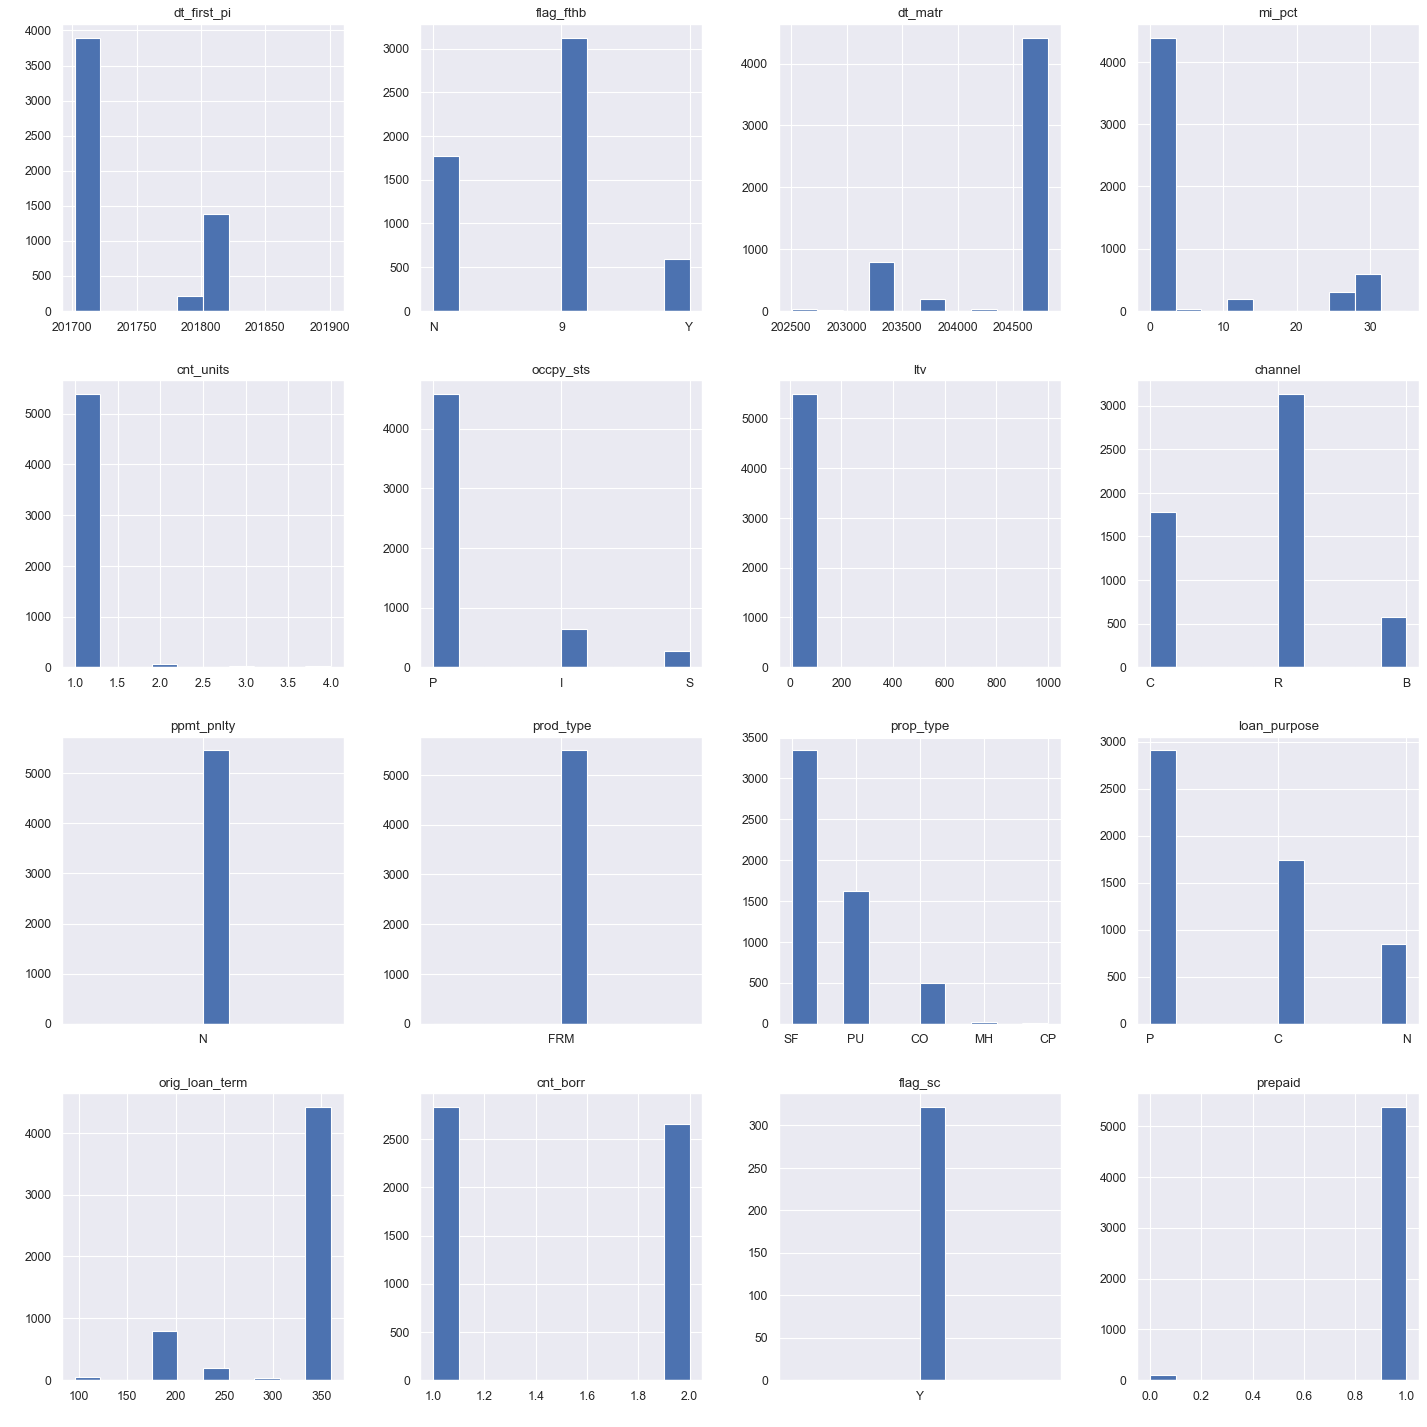

In [154]:
# Identifiers variables are: 'id_loan','cd_msa','zipcode'
# Long catgotical variables are: 'st', 'servicer_name', 'seller_name'
# Numerical variables are: 'fico', 'orig_upb', 'int_rt','cltv','dti'
exclude_var = ['id_loan','cd_msa','zipcode','st', 'servicer_name', 'seller_name','fico', 'orig_upb', 'int_rt','cltv','dti']

columns_to_plot = [col for col in X_train.columns if col not in exclude_var]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 18))
axes = axes.flatten()
fig.patch.set_facecolor('white')

for i, column in enumerate(columns_to_plot):
    X_train[column].hist(ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel(' ')
    axes[i].set_ylabel(' ')

for j in range(len(columns_to_plot), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**identifiers** `id_loan` is an unique identifiers with no duplicates in this dataset. On the contrary, `zipcode` is not an unique identifier, observations are 5-digit area codes. Similarly, `cd_msa` are 5-digit codes of Metropolitan Statistical Area (MSA) regions, where the complete list of regions can be found [here](https://www2.census.gov/programs-surveys/cps/methodology/Geographic%20Coding%20-%20Metro%20Areas%20(since%20August%202005).pdf).


In [ ]:
# Check for duplicates in 'id_loan' variable
duplicates = d[d.duplicated(subset=['id_loan'], keep=False)]

if not duplicates.empty:
    print("Duplicates found in 'id_loan' variable:")
    print(duplicates)
else:
    print("No duplicates found in 'id_loan' variable.")

d['zipcode_str'] = d['zipcode'].astype(str)

No duplicates found in 'id_loan' variable.


**Feature Engineering** 

`flag_fthb` replace all 9s with NaN and map Y as 1, N as 0. 

`cnt_units` One-hot encoding 4 levels: 1,2,3,4.

`occpy_sts` One-hot encoding 3 levels: P,S,I.

`cltv`, `dti`,`ltv` discard 1 NA.

`channel` One-hot encoding 4 levels: R,B,C,T.

`ppmy_pnlty` disccard all NaN, map Y as 1, N as 0. Note there's no Y in this dataset.

`prod_type` discard this feature, all observations are "FRM" (fixed-rate mortgage). Have no predictive power to adjustable-rate mortgage.

`prop_type` One-hot encoding to 5 levels: 'SF' 'PU' 'MH' 'CO' 'CP'.

`loan_purpose` One-hot encoding to 4 levels: C,N,R,P.

`cnt_bnrr` Map 1($1$ borrower) to 0 and 2( $>1$ borrower) to 1.

`flag_sc` discard this feature, all observations are either Y or NaN. Have no predictive power.


In [155]:
# Replace '9' values with NaN
X_train['flag_fthb'] = X_train['flag_fthb'].replace('9', np.nan)
X_test['flag_fthb'] = X_test['flag_fthb'].replace('9', np.nan)
# Map 'Y' to 1 and 'N' to 0
X_train['flag_fthb'] = X_train['flag_fthb'].map({'Y': 1, 'N': 0})
X_test['flag_fthb'] = X_test['flag_fthb'].map({'Y': 1, 'N': 0})

/var/folders/lr/p72hbsp95kn2nhmdl6xmf3w40000gp/T/ipykernel_25562/3483908766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['flag_fthb'] = X_train['flag_fthb'].replace('9', np.nan)
/var/folders/lr/p72hbsp95kn2nhmdl6xmf3w40000gp/T/ipykernel_25562/3483908766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['flag_fthb'] = X_test['flag_fthb'].replace('9', np.nan)
/var/folders/lr/p72hbsp95kn2nhmdl6xmf3w40000gp/T/ipykernel_25562/3483908766.py:5: SettingWithCopyWarning: 
A value is trying to 

In [157]:
# There's no NA in 'cnt_units', apply one-hot encoding to values 1, 2, 3, 4
X_train = pd.get_dummies(X_train, columns=['cnt_units'], prefix='cnt_units')
X_test = pd.get_dummies(X_test, columns=['cnt_units'], prefix='cnt_units')

In [158]:
# There's no NA in 'occpy_sts', apply one-hot encoding to P,S,I
X_train = pd.get_dummies(X_train, columns=['occpy_sts'], prefix='occpy_sts')
X_test = pd.get_dummies(X_test, columns=['occpy_sts'], prefix='occpy_sts')

In [159]:
# Filter out instances of 999 from 'cltv','dti','ltv'
X_train = X_train[X_train['cltv'] != 999]
X_test = X_test[X_test['cltv'] != 999]
X_train = X_train[X_train['dti'] != 999]
X_test = X_test[X_test['dti'] != 999]
X_train = X_train[X_train['ltv'] != 999]
X_test = X_test[X_test['ltv'] != 999]
# Discard missing values in the 'fico'
X_train = X_train.dropna(subset=['fico'])
X_test = X_test.dropna(subset=['fico'])

In [160]:
# There's no NA in 'channel', apply one-hot encoding to R,B,C,T.
X_train = pd.get_dummies(X_train, columns=['channel'], prefix='channel')
X_test = pd.get_dummies(X_test, columns=['channel'], prefix='channel')

In [162]:
# Discard all NaN observations from the 'ppmy_pnlty' column
X_train = X_train.dropna(subset=['ppmt_pnlty'])
X_test = X_test.dropna(subset=['ppmt_pnlty'])
# Encode 'N' as 0 and 'Y' as 1, note there's no Y in d dataframe
X_train['ppmt_pnlty'] = X_train['ppmt_pnlty'].map({'N': 0, 'Y': 1})
X_test['ppmt_pnlty'] = X_test['ppmt_pnlty'].map({'N': 0, 'Y': 1})

/var/folders/lr/p72hbsp95kn2nhmdl6xmf3w40000gp/T/ipykernel_25562/4129523053.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ppmt_pnlty'] = X_train['ppmt_pnlty'].map({'N': 0, 'Y': 1})


In [163]:
# Discard the 'prod_type'
X_train = X_train.drop(columns=['prod_type'])
X_test = X_test.drop(columns=['prod_type'])

In [164]:
# There's no NA in 'prop_type', apply one-hot encoding to 'SF' 'PU' 'MH' 'CO' 'CP'
X_train = pd.get_dummies(X_train, columns=['prop_type'], prefix='prop_type')
X_test = pd.get_dummies(X_test, columns=['prop_type'], prefix='prop_type')

In [165]:
# There's no NA in 'loan_purpose', apply one-hot encoding to 4 levels: C,N,R,P.
X_train = pd.get_dummies(X_train, columns=['loan_purpose'], prefix='loan_purpose')
X_test = pd.get_dummies(X_test, columns=['loan_purpose'], prefix='loan_purpose')

In [166]:
# Map 1 to 0 and 2 to 1
X_train['cnt_borr'] = X_train['cnt_borr'].map({1: 0, 2: 1})
X_test['cnt_borr'] = X_test['cnt_borr'].map({1: 0, 2: 1})

In [167]:
# Discard the 'flag_sc'
X_train = X_train.drop(columns=['flag_sc'])
X_test = X_test.drop(columns=['flag_sc'])

In [168]:
X_train

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cltv,dti,orig_upb,ltv,int_rt,ppmt_pnlty,st,zipcode,id_loan,orig_loan_term,cnt_borr,seller_name,servicer_name,prepaid,cnt_units_1,cnt_units_2,cnt_units_3,cnt_units_4,occpy_sts_I,occpy_sts_P,occpy_sts_S,channel_B,channel_C,channel_R,prop_type_CO,prop_type_CP,prop_type_MH,prop_type_PU,prop_type_SF,loan_purpose_C,loan_purpose_N,loan_purpose_P
2024,790.0,201706,0.0,204705,47664.0,0,80,19,147000,80,4.250,0,MI,48000,F117Q2060671,360,1,UNITEDSHOREFINANCIAL,Other servicers,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1
3370,620.0,201710,NaN,203209,NaN,0,70,32,80000,70,4.125,0,TX,79300,F117Q3098359,180,0,Other sellers,Other servicers,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0
2124,763.0,201707,0.0,204706,13900.0,0,80,37,288000,80,4.050,0,ND,58500,F117Q2079320,360,1,"CALIBERHOMELOANS,INC","CALIBERHOMELOANS,INC",1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1
549,734.0,201703,NaN,204702,NaN,0,49,45,220000,49,4.625,0,CO,80400,F117Q1075441,360,0,Other sellers,Other servicers,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
4550,757.0,201801,NaN,204712,41740.0,0,50,48,424000,50,4.125,0,CA,92000,F117Q4223829,360,1,"WELLSFARGOBANK,NA","WELLSFARGOBANK,NA",1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,733.0,201711,NaN,203710,37964.0,0,70,30,133000,70,5.125,0,PA,19100,F117Q3253203,240,1,"WELLSFARGOBANK,NA","WELLSFARGOBANK,NA",1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0
5191,791.0,201805,0.0,204804,40420.0,0,42,49,190000,42,4.625,0,IL,61000,F118Q1197710,360,1,Other sellers,Other servicers,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1
5226,641.0,201805,NaN,204804,35614.0,0,75,42,649000,75,5.875,0,NJ,7000,F118Q1217267,360,1,"LOANDEPOTCOM,LLC",Other servicers,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0
5390,665.0,201807,NaN,204806,NaN,0,71,42,170000,71,5.500,0,IL,62400,F118Q2025127,360,1,Other sellers,Other servicers,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0


In [150]:
unique_occurrences = d['flag_sc'].unique()
print(unique_occurrences)


[nan 'Y']


In [139]:
smallest_value = d['orig_loan_term'].min()
largest_value = d['orig_loan_term'].max()

print("Smallest value in column 'dt_matr':", smallest_value)
print("Largest value in column 'dt_matr':", largest_value)


Smallest value in column 'dt_matr': 96
Largest value in column 'dt_matr': 360


In [89]:
d

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,int_rt,channel,ppmt_pnlty,prod_type,st,prop_type,zipcode,id_loan,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,prepaid,default
0,709.0,201703,9,204702,NaN,12,1,P,84,26,310000.0,84,3.625,R,N,FRM,IA,SF,51300,F117Q1000376,N,360,2,Other sellers,Other servicers,NaN,0,1
1,649.0,201703,9,203202,33124.0,0,1,P,52,22,190000.0,52,NaN,R,N,FRM,FL,SF,33100,F117Q1000418,C,180,2,Other sellers,Other servicers,NaN,1,0
2,747.0,201703,9,203702,41180.0,0,1,I,43,20,61000.0,43,4.000,R,N,FRM,MO,SF,63100,F117Q1000479,N,240,2,Other sellers,Other servicers,NaN,1,0
3,711.0,201703,9,204702,20260.0,0,1,I,80,21,90000.0,80,4.625,R,N,FRM,MN,SF,55800,F117Q1000523,P,360,2,Other sellers,Other servicers,NaN,1,0
4,751.0,201703,N,204702,NaN,35,1,P,95,24,112000.0,95,4.250,R,N,FRM,TX,PU,75900,F117Q1000719,P,360,1,Other sellers,ARVESTCENTRALMTGECO,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6099,725.0,201811,9,204810,41500.0,0,1,P,59,40,160000.0,59,5.000,C,N,FRM,CA,CO,93900,F118Q3263412,C,360,2,"WELLSFARGOBANK,NA","WELLSFARGOBANK,NA",NaN,1,0
6100,768.0,201809,Y,204808,31084.0,0,1,P,79,46,500000.0,79,5.000,B,NaN,FRM,CA,SF,90000,F118Q3263943,P,360,2,"STEARNSLENDING,LLC",Other servicers,Y,1,0
6101,752.0,201811,9,203310,39900.0,0,1,I,80,12,213000.0,80,4.875,R,N,FRM,NV,SF,89400,F118Q3265340,P,180,2,Other sellers,Other servicers,NaN,1,0
6102,777.0,201811,N,204810,31084.0,0,1,P,80,48,238000.0,80,5.125,C,N,FRM,CA,SF,93500,F118Q3267905,P,360,1,AMERIHOMEMTGECOMPANY,AMERIHOMEMTGECOMPANY,NaN,1,0


# Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, interaction terms, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validating it.*

*For example if you considered a linear regression model, a polynomial regression, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide comparison of your model with baseline model(s) on the test data but only briefly describe the baseline model(s) considered*

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a government official or charity directy, who is understands the pressing challenges associated with ageining and dementia but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also mention potential limitations of your model.*

*Finally, you should include recommendations on potential lifestyle changes or governmental/societal interventions to reduce dementia risk.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# References

*Include references if any*

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] Converting notebook project2.ipynb to pdf
[NbConvertApp] Writing 448929 bytes to project2.pdf


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a2a9ec8d-a343-4210-b36b-f9db26268fc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>